# 頂点被覆問題

このセクションでは、`JijModeling` と `Qamomile` ライブラリを用いて、QAOAを使って頂点被覆問題を解いていきます。

まずは、使用する主要なライブラリをインストールおよびインポートしましょう。

In [1]:
# !pip install qamomile[qiskit,quri-parts]
# !pip install pylatexenc

In [2]:
from collections import defaultdict

import jijmodeling as jm
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import ommx.v1
import qiskit as qk
import qiskit.primitives as qk_pr
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
from scipy.optimize import minimize

import qamomile.core as qm
from qamomile.core.circuit.drawer import plot_quantum_circuit
import qamomile.qiskit as qm_qk

## 頂点被覆問題の定式化

頂点被覆問題の定式化を考えてみましょう。

2値変数 $x_i$ を定義し、頂点 $i$ が集合 $S$ に含まれる場合は $x_i = 1$、含まれない場合は $x_i = 0$ とします。集合 $S$ のサイズを表す目的関数は、以下のように表されます。

$$
\sum_{i \in V} x_i
$$

制約条件は、すべての辺が被覆されていることであり、つまり各辺に対して、その両端点のうち少なくとも一方が集合 $S$ に含まれている必要があります。これは次のように定式化できます。

$$
x_{e_0} + x_{e_1} \geq 1 \quad \forall e \in E
$$

まとめると、頂点被覆問題は次のように定式化できます。

$$
\begin{align}
&\min \sum_{i \in V} x_i \\
\text{s.t. } &x_{e_0} + x_{e_1} \geq 1 \quad \forall e \in E
\end{align}
$$

## JijModeling を使った問題モデルの作成

上記の定式化を記述し、それを基に JijModeling を使って問題モデルを作成します。`Placeholder` はデータとして代入される値を定義し、`BinaryVar` は意思決定変数を定義し、`Element` は総和に使われる添字を定義します。出力を確認することで、定式化が正しいことを確認できます。

In [3]:
def vertex_cover_problem() -> jm.Problem:
    # 変数を定義する
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    x = jm.BinaryVar("x", shape=(V,))
    i = jm.Element("i", belong_to=(0, V))
    e = jm.Element("e", belong_to=E)

    # 問題を定義する
    problem = jm.Problem("Vertex Cover Problem")
    # 各辺の少なくとも一方の頂点が被覆に含まれるようにする
    # problem += jm.Constraint("cover", x[e[0]] + x[e[1]] >= 1, forall=e)
    # 被覆に含まれる頂点の数を最小化する
    problem += jm.sum(i, x[i]) + jm.sum(e, (x[e[0]] + x[e[1] - 1.5]) ** 2) 
    return problem


problem = vertex_cover_problem()
problem

## インスタンスデータの準備

次に、以下のグラフに対して頂点被覆問題を解きます。ここで解こうとしている具体的な問題のデータをインスタンスデータと呼びます。

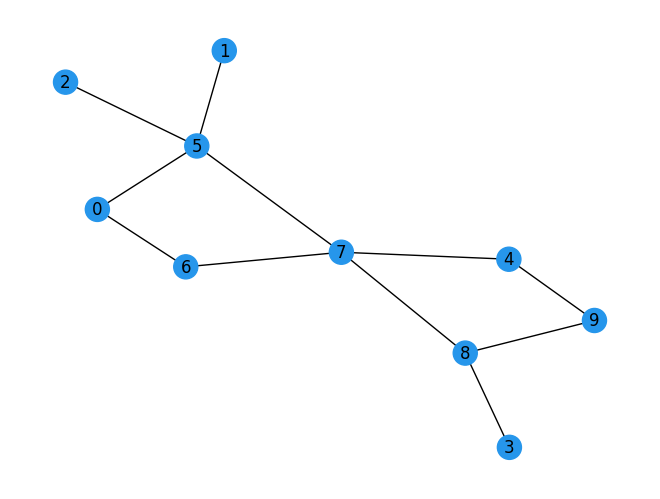

In [4]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
G.add_edges_from(
    [
        (0, 6),
        (0, 5),
        (1, 5),
        (2, 5),
        (3, 8),
        (4, 9),
        (4, 7),
        (5, 7),
        (6, 7),
        (7, 8),
        (8, 9),
    ]
)
positions = nx.spring_layout(G)
color = ["#2696EB"] * G.number_of_nodes()
nx.draw(G, node_color=color, pos=positions, with_labels=True)

## コンパイル済みインスタンスの作成

先ほど作成した定式化とインスタンスデータを用いて、`JijModeling.Interpreter` と `ommx.Instance` によってコンパイルを行います。この処理によって、インスタンスデータが代入された中間表現が得られます。

In [5]:
inst_E = [list(edge) for edge in G.edges]
num_nodes = G.number_of_nodes()
instance_data = {"V": num_nodes, "E": inst_E}
num_qubits = num_nodes
compiled_instance = jm.Interpreter(instance_data).eval_problem(problem)

## コンパイル済みインスタンスのQAOA回路およびハミルトニアンへの変換

コンパイル済みインスタンスから、QAOA回路とハミルトニアンを生成します。これには `qm.qaoa.QAOAConverter` を使用します。

このクラスのインスタンスを作成し、`ising_encode` を使用することで、内部的にIsingハミルトニアンを生成できます。QUBOへの変換時に現れるパラメータはここで設定可能ですが、設定しなければデフォルト値が使用されます。

Isingハミルトニアンが生成された後、`get_qaoa_ansatz` および `get_cost_hamiltonian` メソッドを使用して、それぞれQAOAの量子回路とハミルトニアンを生成できます。ここではQAOAのレイヤー数 $p$ を3に固定します。

In [6]:
qaoa_converter = qm.qaoa.QAOAConverter(compiled_instance)
# Isingハミルトニアンへのエンコードを行う
qaoa_converter.ising_encode()
# QAOA回路を取得する
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=3)
# コストハミルトニアンを取得する
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()

## QAOA回路の可視化

Qamomile は量子回路を可視化するためのメソッドを提供しています。`plot_quantum_circuit` 関数を使用することで、QAOAの量子回路を可視化することができます。

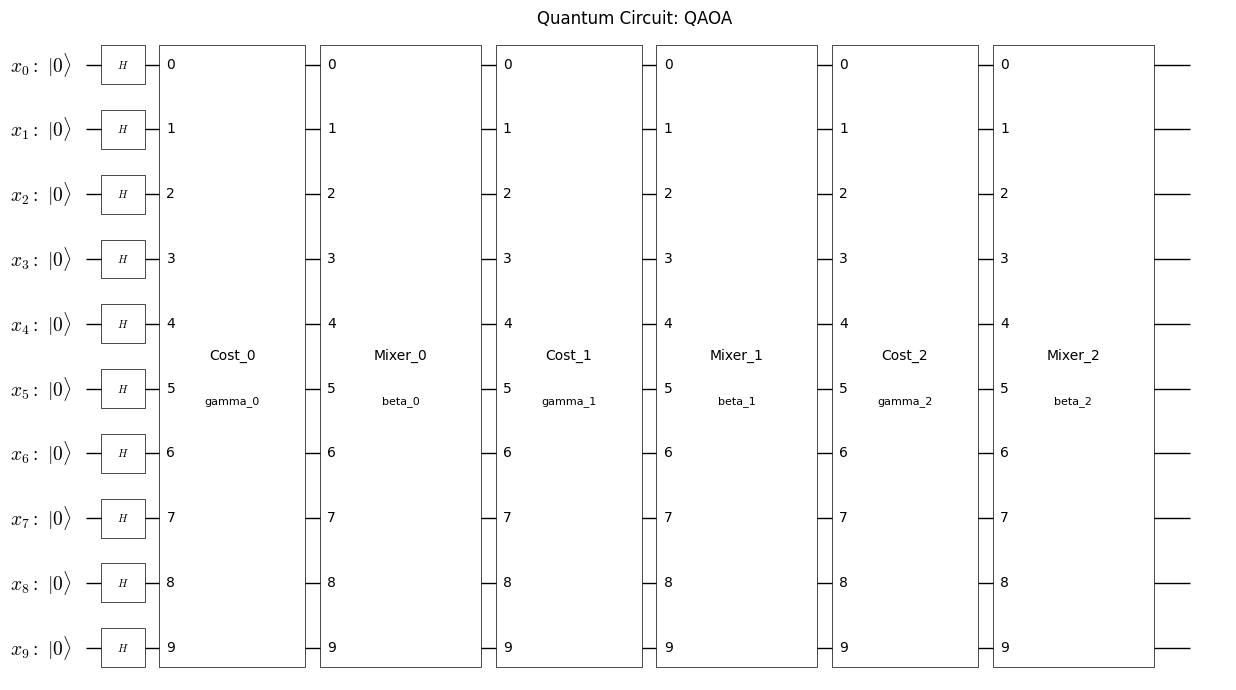

In [7]:
plot_quantum_circuit(qaoa_circuit)

## 得られたQAOA回路とハミルトニアンのQiskit用変換

ここでは、`qamomile.qiskit.QiskitTranspiler` のコンバータを使用して、Qiskit用のQAOA回路とハミルトニアンを生成します。  
`QiskitTranspiler.transpile_circuit` および `QiskitTranspiler.transpile_hamiltonian` という2つのメソッドを使用することで、QAOA回路とハミルトニアンをQiskitで利用可能な形式に変換できます。  
これにより、Qiskitの量子計算フレームワークを活用して実行および解析が可能になります。

In [8]:
qk_transpiler = qm_qk.QiskitTranspiler()
# QAOA回路をQiskitにトランスパイルする  
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
# QAOAハミルトニアンをQiskitにトランスパイルする
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_hamiltonian)
qk_hamiltonian

SparsePauliOp(['IIIIIIIIIZ', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIZIIIIII', 'IIIIZIIIII', 'IIZIIIIIII', 'IZIIIIIIII', 'ZIIIIIIIII', 'IIIIIIZIIZ', 'IIIIIZIIIZ', 'IIIIIIZIZI', 'IIIIIIZZII', 'IIIZIIZIII', 'IIIIZZIIII', 'IIZIIZIIII', 'IIIZZIIIII', 'IIZZIIIIII', 'IZZIIIIIII', 'IIIIIIIIII'],
              coeffs=[-2.5+0.j, -4.5+0.j, -3.5+0.j, -1.5+0.j, -1.5+0.j, -3.5+0.j, -4.5+0.j,
 -3.5+0.j, -1.5+0.j, -0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,
  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j, 22. +0.j])

## QAOAの実行

QAOAを実行してパラメータの最適化を行います。ここでは、最適化アルゴリズムとしてCOBYLAを使用します。

In [9]:
cost_history = []
aer_sim = AerSimulator()
qk_circuit = qk.transpile(qk_circuit, aer_sim)
estimator = EstimatorV2()


# コスト推定関数
def estimate_cost(param_values):
    job = estimator.run([(qk_circuit, qk_hamiltonian, param_values)])
    result = job.result()[0]
    cost = result.data["evs"]
    cost_history.append(cost)
    return cost


# QAOAの初期パラメータ
initial_params = [
    np.pi / 8,
    np.pi / 4,
    3 * np.pi / 8,
    np.pi / 2,
    np.pi / 2,
    3 * np.pi / 8,
]

# COBYLAを用いたQAOAの最適化実行
result = minimize(
    estimate_cost,
    initial_params,
    method="COBYLA",
    options={"maxiter": 1500},
)

print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 10.382266563384672
       x: [ 1.593e+00  8.375e-01  1.131e+00  1.686e+00  1.348e+00
            7.099e-01]
    nfev: 270
   maxcv: 0.0


## 結果の可視化

最適化を繰り返すことで、エネルギーが減少して収束していく様子を観察できます。

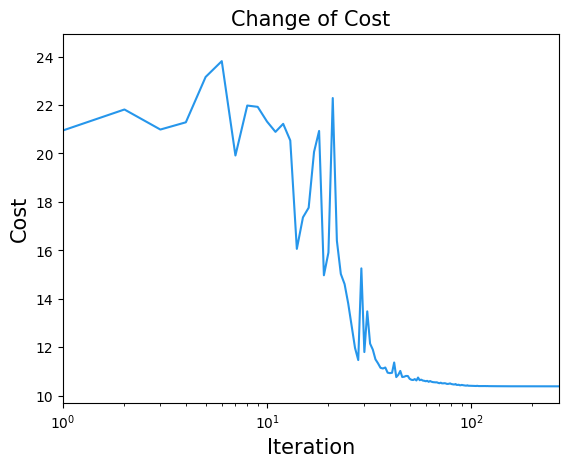

In [10]:
plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xscale("log")
plt.xlim(1, result.nfev)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

最適化されたパラメータを用いて、Qiskit の `StatevectorSampler` を実行してみましょう。

In [11]:
# 最適化されたQAOA回路の実行
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
job = sampler.run([(qk_circuit, result.x)], shots=1000)
job_result = job.result()[0]
qaoa_counts = job_result.data["meas"]

## 結果の評価

先ほど取得したジョブカウントから、`qaoa_converter.decode` を使って sampleset に変換します。  
sampleset では実行可能な解（制約を満たす解）のみを選択することができ、目的関数値の分布を確認することができます。

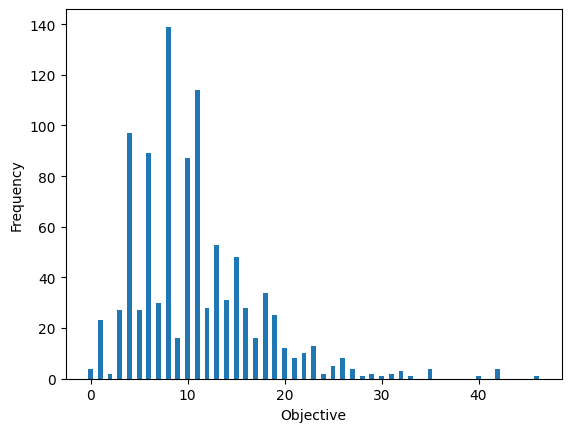

In [12]:
sampleset = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])

# 各エネルギー値の出現回数を蓄積するための辞書を初期化
frequencies = defaultdict(int)

# エネルギー値を丸める精度を定義
for entry in sampleset.raw.objectives.entries:
    energy = round(entry.value, ndigits = 3)  
    frequencies[energy] += len(entry.ids)


plt.bar(frequencies.keys(), frequencies.values(), width=0.5)
plt.xlabel('Objective')
plt.ylabel('Frequency')
plt.show()

## 解のプロット

得られた結果の中から、目的関数値を最小にする解を選び、それをプロットします。  
（オレンジ色の頂点は頂点被覆に含まれる頂点を表しています。）

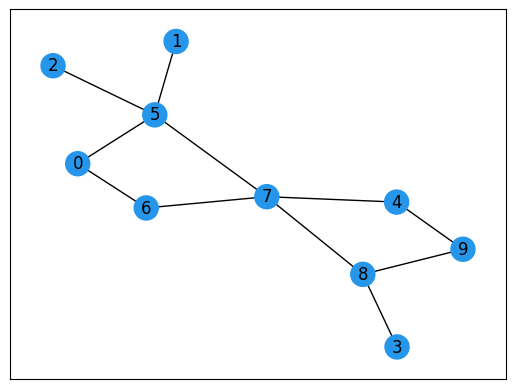

In [13]:
def plot_graph_coloring(graph: nx.Graph, sampleset: ommx.v1.SampleSet):
    # 実行可能な解を抽出
    best_sol = sampleset.best_feasible_unrelaxed()
    # 頂点の色リストを初期化
    node_colors = ["#2696EB"] * instance_data["V"]
    # 頂点の色を設定
    x_value = best_sol.extract_decision_variables("x")
    for t, v in x_value.items():
        if v == 1:
            node_colors[t[0]] = "#EA9b26"
    # 図を作成
    nx.draw_networkx(graph, node_color=node_colors, pos=positions, with_labels=True)
    plt.show()


plot_graph_coloring(G, sampleset)

確かに、頂点被覆が得られていることが確認できます。